In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from helper_functions import (
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction
    )

from SqueezeNet_for_time_series import SqueezeNet

2024-06-20 12:26:37.904048: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 12:26:37.937644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 12:26:37.937672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 12:26:37.938551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 12:26:37.943998: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 12:26:37.944944: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
sample_rate = 16000

In [4]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(test_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.


2024-06-20 12:26:41.017084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-20 12:26:41.017459: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-20 12:26:41.100652: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-06-20 12:26:41.105765: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [5]:
x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_dataset, data_type="time-series")
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_dataset, data_type="time-series")
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_dataset, data_type="time-series")

In [6]:
for i in x_train_np:
    print(i.shape)
    break

(48000, 1)


### Model training

In [11]:
print("Model summary without compression: ")
model_without_compression = SqueezeNet(input_shape=(48000, 1), nb_classes=2)
model_without_compression.summary()

Model summary without compression: 
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 48000, 1)]           0         []                            
                                                                                                  
 conv1 (Conv1D)              (None, 24000, 96)            768       ['input_5[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling1D)     (None, 11999, 96)            0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv1D)      (None, 11999, 16)            1552      ['maxpool1[0][0]']            
                                                        

In [12]:
print("Model summary with compression: ")

model = SqueezeNet(input_shape=(48000, 1), nb_classes=2, compression=0.3)
model.summary()

Model summary with compression: 
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 48000, 1)]           0         []                            
                                                                                                  
 conv1 (Conv1D)              (None, 24000, 28)            224       ['input_6[0][0]']             
                                                                                                  
 maxpool1 (MaxPooling1D)     (None, 11999, 28)            0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv1D)      (None, 11999, 4)             116       ['maxpool1[0][0]']            
                                                           

In [9]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 10
history = model.fit(
    train_dataset,
    epochs=EPOCHS
)

Epoch 1/10


/home/polina/TinyBirdSingingDetection/venv/lib/python3.9/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


353/353 [==============================] - 469s 1s/step - loss: 0.4229 - accuracy: 0.7899
Epoch 2/10
353/353 [==============================] - 477s 1s/step - loss: 0.3199 - accuracy: 0.8563
Epoch 3/10
353/353 [==============================] - 481s 1s/step - loss: 0.3210 - accuracy: 0.8566
Epoch 4/10
353/353 [==============================] - 472s 1s/step - loss: 0.3010 - accuracy: 0.8654
Epoch 5/10
353/353 [==============================] - 560s 2s/step - loss: 0.3006 - accuracy: 0.8660
Epoch 6/10
353/353 [==============================] - 502s 1s/step - loss: 0.2918 - accuracy: 0.8698
Epoch 7/10
353/353 [==============================] - 508s 1s/step - loss: 0.2776 - accuracy: 0.8758
Epoch 8/10
353/353 [==============================] - 497s 1s/step - loss: 0.2547 - accuracy: 0.8923
Epoch 9/10
353/353 [==============================] - 495s 1s/step - loss: 0.1709 - accuracy: 0.9326
Epoch 10/10
353/353 [==============================] - 496s 1s/step - loss: 0.1436 - accuracy: 0.9443


In [10]:
print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model, x_test_np, y_test_np, model_format="keras")

Validation dataset:
44/44 [==============================] - 19s 425ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 96.52%
Recall: 91.95%
Precision: 97.75%
F1-score: 94.76%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9461470006413389

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9490614960562602

Test dataset:
44/44 [==============================] - 17s 382ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 96.63%
Recall: 94.10%
Precision: 95.57%
F1-score: 94.83%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9486317826775494

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9482568799678605


In [11]:
print("For Test dataset:")
evaluate_time_of_prediction(model, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


For Test dataset:
Accuracy: 96.63%
Recall: 94.10%
Precision: 95.57%
F1-score: 94.83%

Time to make a prediction for a single data point
Mean: 0.064 seconds
Max: 0.293 seconds
Min: 0.057 seconds


In [12]:
BASE_MODEL_FILE_NAME = "time_series_models_from_notebooks/squeezenet/squeezenet30%_time_series_16kHz_baseline.keras"
model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model file name:  time_series_models_from_notebooks/squeezenet/squeezenet30%_time_series_16kHz_baseline.keras
File size: 0.519 Megabytes


In [13]:
model = tf.keras.models.load_model(BASE_MODEL_FILE_NAME)

In [16]:
# model.summary()

In [15]:
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "KB")

File size: 531.003 Kilobytes


### Convert to Tensorflow Lite model 

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\polin\AppData\Local\Temp\tmpshwgk9_3\assets


INFO:tensorflow:Assets written to: C:\Users\polin\AppData\Local\Temp\tmpshwgk9_3\assets


Saved artifact at 'C:\Users\polin\AppData\Local\Temp\tmpshwgk9_3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 144000, 1), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2474501771104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501789824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501791584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501822592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501823296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501823472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501838448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501838096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501870688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501870512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  247450

In [22]:
lite_model_predict_dataset(tflite_model, x_val_np, y_val_np)

Accuracy: 91.67%
Recall: 91.99%
Precision: 84.26%
F1-score: 88.42%


[array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], 

In [23]:
lite_model_predict_dataset(tflite_model, x_test_np, y_test_np)

Accuracy: 89.30%
Recall: 90.47%
Precision: 78.04%
F1-score: 85.23%


[array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], 

In [34]:
TF_LITE_MODEL_FILE_NAME = "models_from_notebooks/squeezenet_30%_time_series_sr_48000.tflite"
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File size: 0.691 Megabytes


### Dynamic range quantization

In [25]:
dynamic_range_quant_converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)
dynamic_range_quant_converter.optimizations = [tf.lite.Optimize.DEFAULT]
dynamic_range_quant_model = dynamic_range_quant_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\polin\AppData\Local\Temp\tmpgpor3pvf\assets


INFO:tensorflow:Assets written to: C:\Users\polin\AppData\Local\Temp\tmpgpor3pvf\assets


Saved artifact at 'C:\Users\polin\AppData\Local\Temp\tmpgpor3pvf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 144000, 1), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2474501771104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501789824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501791584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501822592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501823296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501823472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501838448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501838096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501870688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474501870512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  247450

In [26]:
lite_model_predict_dataset(dynamic_range_quant_model, x_val_np, y_val_np)

Accuracy: 92.10%
Recall: 92.06%
Precision: 85.94%
F1-score: 88.84%


[array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], 

In [27]:
lite_model_predict_dataset(dynamic_range_quant_model, x_test_np, y_test_np)

Accuracy: 89.02%
Recall: 89.70%
Precision: 78.50%
F1-score: 84.59%


[array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], 

In [33]:
TF_LITE_MODEL_DYNAMIC_RANGE_QUANT_FILE_NAME = "models_from_notebooks/squeezenet_30%_time_series_sr_dynamic_range_quantization.tflite"
open(TF_LITE_MODEL_DYNAMIC_RANGE_QUANT_FILE_NAME, "wb").write(dynamic_range_quant_model)
convert_bytes(get_file_size(TF_LITE_MODEL_DYNAMIC_RANGE_QUANT_FILE_NAME), "KB")

File size: 220.531 Kilobytes


In [75]:
length_of_audio = 144000
sample_rate = 48000

Found 2 files belonging to 2 classes.


[-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ...  4.2419434e-03
  3.5400391e-03  1.3122559e-03]


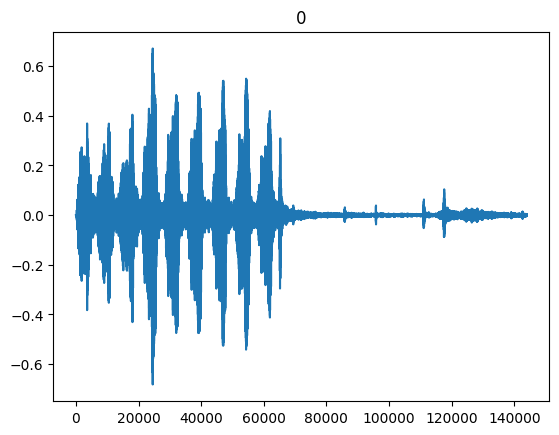

[-0.01583862 -0.01712036 -0.01174927 ...  0.          0.
  0.        ]


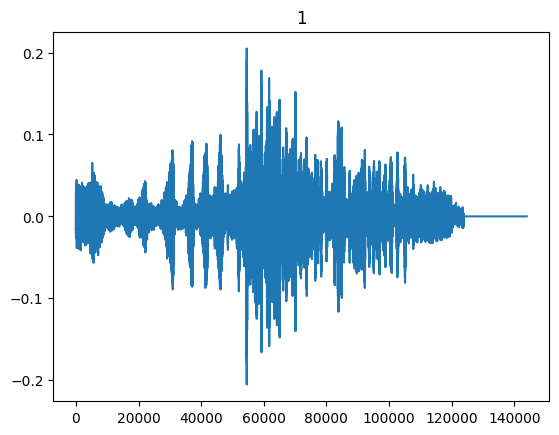

Accuracy: 50.00%
Recall: 50.00%
Precision: 0.00%
F1-score: 0.00%

True:  [0, 1]
Predicted:  [array([0], dtype=int64), array([0], dtype=int64)]


c:\Users\polin\anaconda3\envs\ag14\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
# 1 - target, 0 - non-target
toy_dataset_ds = tf.keras.utils.audio_dataset_from_directory("C:\\Users\\polin\\Bird_song_detection\\dataset\\diff_length", labels='inferred', output_sequence_length=length_of_audio)
# toy_dataset_spectrograms = create_spectrograms_from_audio_dataset(toy_dataset_ds, sample_rate = sample_rate)
x_toy_np, y_toy_np = convert_prefetchdataset_to_numpy_arrays(toy_dataset_ds)

# We take just one point out of two from this toy dataset and predict it 
x_data = []
y_data = []
for i in range(len(x_toy_np)):
    print(x_toy_np[i].flatten())
    x_toy_one_point = x_toy_np[i].flatten()
    y_toy_one_point = y_toy_np[i]

    # Make a plot (plot of the last i will be visible)
    # x_toy_one_point_without_color_channel, _ = squeeze(x_toy_one_point)
    plt.plot(x_toy_one_point)
    plt.title(y_toy_one_point)
    plt.show()

    x_data.append(x_toy_np[i])
    y_data.append(y_toy_one_point)


y_pred = lite_model_predict_dataset(dynamic_range_quant_model, x_data, y_data)
print("\nTrue: ", y_data)
print("Predicted: ", y_pred)

In [77]:
# From validation dataset:
files_names = [
               ("0.920_0005_789668.wav", 1),
               ("0.940_0015_139518451.wav", 1),
               ("0.950_0027_206237.wav", 1),
               ("0.970_0095_127306.wav", 1),
               ("0.960_0043_27576.wav", 1),
               ("0.920_0015_787431.wav", 0), # bird
               ("0.960_0049_203902861.wav", 0), # bird
               ("1.000_0001_2I2IzXnhmtc_120.wav", 0), # cough
               ("1.000_0002_4vxBWzOWBZU_270.wav", 0), #speech
               ("1.000_0003_4jWZLisG5yA_30.wav", 0), # music
               ]
file_path = "C:/Users/polin/Bird_song_detection/dataset/validation/"


desired_length = length_of_audio
sample_rate = sample_rate
x_data = []
y_data = []
for file_data in files_names:
    # print("file name: ", file_data[0])
    if file_data[1] == 1:
        class_encoded = "target"
    elif file_data[1] == 0:
        class_encoded = "non_target"

    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_path+class_encoded+"/"+file_data[0]))
    audio_length = tf.shape(audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
    else:
        audio = audio[:desired_length]
        
    x_data.append(audio)
    y_data.append(file_data[1])

y_pred = lite_model_predict_dataset(dynamic_range_quant_model, x_data, y_data)
print("\nTrue: ", y_data)
print("Predicted: ", y_pred)
if all(x == y for x, y in zip(y_data, y_pred)):
    print("All data points were predicted correctly!")
else:
    print("Prediction was not correct for some points.")


Accuracy: 100.00%
Recall: 100.00%
Precision: 100.00%
F1-score: 100.00%

True:  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Predicted:  [array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64)]
All data points were predicted correctly!


In [78]:
# From testing dataset:
files_names = [
               ("0.920_0021_R21_2022_02_22_07_34_44.wav", 1),
               ("0.930_0008_R21_2022_02_23_09_26_54.wav", 1),
               ("0.940_0049_86290.wav", 1),
               ("0.950_0097_171265.wav", 1),
               ("0.950_0088_324445971.wav", 1),
               ("0.920_0019_457390981.wav", 0), # bird
               ("0.980_0035_236963.wav", 0), # bird
               ("1.000_0001_2t-2M-FoZkQ_0.wav", 0), # speech and phone call
               ("1.000_0001_-450EsuQYao_110.wav", 0), #speech and bird singing on the back ground
               ("1.000_0002_Bpq3_eIfVQc_30.wav", 0), # motocycle and dog
               ]
file_path = "C:/Users/polin/Bird_song_detection/dataset/testing/"


desired_length = length_of_audio
sample_rate = sample_rate
x_data = []
y_data = []
for file_data in files_names:
    # print("file name: ", file_data[0])
    if file_data[1] == 1:
        class_encoded = "target"
    elif file_data[1] == 0:
        class_encoded = "non_target"

    audio, sr = tf.audio.decode_wav(tf.io.read_file(file_path+class_encoded+"/"+file_data[0]))
    audio_length = tf.shape(audio)[0]
    if audio_length < desired_length:
        audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
    else:
        audio = audio[:desired_length]

    x_data.append(audio)
    y_data.append(file_data[1])

y_pred = lite_model_predict_dataset(dynamic_range_quant_model, x_data, y_data)
print("\nTrue: ", y_data)
print("Predicted: ", y_pred)
if all(x == y for x, y in zip(y_data, y_pred)):
    print("All data points were predicted correctly!")
else:
    print("Prediction was not correct for some points.")

Accuracy: 100.00%
Recall: 100.00%
Precision: 100.00%
F1-score: 100.00%

True:  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Predicted:  [array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64)]
All data points were predicted correctly!


Accuracy: 100.00%
Recall: 100.00%
Precision: 0.00%
F1-score: 0.00%

Predicted:  [array([0], dtype=int64)]


c:\Users\polin\anaconda3\envs\ag14\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\polin\anaconda3\envs\ag14\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


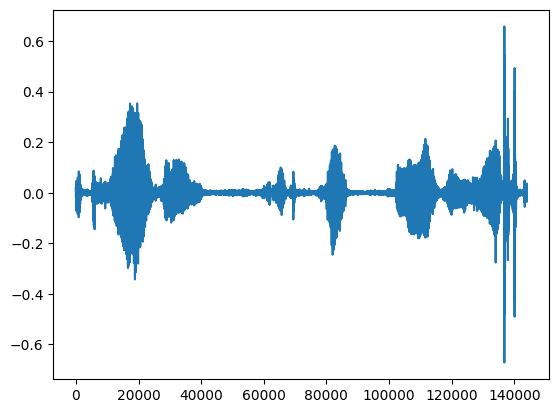

In [79]:
file_name = 'C:/Users/polin/Bird_song_detection/dataset/testing/non_target/1.000_0001_-450EsuQYao_110.wav'
class_encoded = 0
sample_rate = 48000
desired_length = length_of_audio

audio, sr = tf.audio.decode_wav(tf.io.read_file(file_name))
audio_length = tf.shape(audio)[0]
if audio_length < desired_length:
    audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
else:
    audio = audio[:desired_length]

plt.plot(audio)

y_pred = lite_model_predict_dataset(dynamic_range_quant_model, [audio], [class_encoded])
print("\nPredicted: ", y_pred)

In [82]:
directory = 'C:/Users/polin/Bird_song_detection/dataset/validation'


desired_length = length_of_audio
sample_rate = sample_rate
x_data = []
y_data = []
for root, dirs, files in os.walk(directory):
    # Iterate over each file in the current directory
    for file in files:
        # Print or process the file
        full_file_name = os.path.join(root, file)

        if "non_target" in str(full_file_name):
            class_encoded = 0
        elif "target" in str(full_file_name):
            class_encoded = 1

        audio, sr = tf.audio.decode_wav(tf.io.read_file(full_file_name))
        audio_length = tf.shape(audio)[0]
        audio, _ = squeeze(audio) # we need to squeeze audio to create log mel spectrogram
        
        # print(tf.shape(audio))
        if audio_length < desired_length:
            audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
        else:
            audio = audio[:desired_length]
        
        # Get back color channel axis to make a prediction
        audio_with_color_channel = tf.expand_dims(audio, axis=-1).numpy()
        
        x_data.append(audio_with_color_channel)
        y_data.append(class_encoded)

y_pred = lite_model_predict_dataset(dynamic_range_quant_model, x_data, y_data)
print("\nTrue: ", y_data)
print("Predicted: ", y_pred)
if all(x == y for x, y in zip(y_data, y_pred)):
    print("All data points were predicted correctly!")
else:
    print("Prediction was not correct for some points.")

Accuracy: 92.10%
Recall: 92.06%
Precision: 85.94%
F1-score: 88.84%

True:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [83]:
false_predictions = 0
for true_label, pred_label in zip(y_data, y_pred):
    if true_label != pred_label:
        print(true_label)
        false_predictions += 1

false_predictions

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


109

In [84]:
directory = 'C:/Users/polin/Bird_song_detection/dataset/testing'


desired_length = length_of_audio
sample_rate = sample_rate
x_data = []
y_data = []
for root, dirs, files in os.walk(directory):
    # Iterate over each file in the current directory
    for file in files:
        # Print or process the file
        full_file_name = os.path.join(root, file)

        if "non_target" in str(full_file_name):
            class_encoded = 0
        elif "target" in str(full_file_name):
            class_encoded = 1

        audio, sr = tf.audio.decode_wav(tf.io.read_file(full_file_name))
        audio_length = tf.shape(audio)[0]
        audio, _ = squeeze(audio) # we need to squeeze audio to create log mel spectrogram
        
        # print(tf.shape(audio))
        if audio_length < desired_length:
            audio = tf.pad(audio, [[0, desired_length - audio_length]], mode='CONSTANT')
        else:
            audio = audio[:desired_length]
        
        # Get back color channel axis to make a prediction
        audio_with_color_channel = tf.expand_dims(audio, axis=-1).numpy()
        
        x_data.append(audio_with_color_channel)
        y_data.append(class_encoded)

y_pred = lite_model_predict_dataset(dynamic_range_quant_model, x_data, y_data)
print("\nTrue: ", y_data)
print("Predicted: ", y_pred)
if all(x == y for x, y in zip(y_data, y_pred)):
    print("All data points were predicted correctly!")
else:
    print("Prediction was not correct for some points.")

Accuracy: 89.02%
Recall: 89.70%
Precision: 78.50%
F1-score: 84.59%

True:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [85]:
false_predictions = 0
num_of_false_non_target = 0
num_of_false_target = 0
for true_label, pred_label in zip(y_data, y_pred):
    if true_label != pred_label:
        print(true_label)
        if true_label == 0:
            num_of_false_non_target  += 1
        elif true_label == 1:
            num_of_false_target  += 1
        false_predictions += 1

print('false_predictions', false_predictions)
print('num_of_false_non_target', num_of_false_non_target)
print('num_of_false_target', num_of_false_target)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
false_predictions 153
num_of_false_non_target 115
num_of_false_target 38
